Таблицы

## Шаг 1: Импорт библиотек и загрузка данных

In [811]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import joblib

In [812]:
data = pd.read_csv('./appl_score_sample.csv', delimiter=';')

In [813]:
print("Первый взгляд на данные:\n")
data.head()

Первый взгляд на данные:



,CLIENT_ID,SEX,CHILD_FLAG,REALTY_FLAG,ACCOUNTS_FLAG,E_MAIL_FLAG,DCI,PROFIT_FAMILY,UCI,FOREIGN_PASSPORT_FLAG,STANDING_IN_MONTHS_LAST,EDUCATION,TRANSPORT_AMOUNT,Target
0,1,1,0,1,0,1,14370.2002,14370.2002,0.0,0,26,3,1,1
1,2,1,1,1,0,0,28312.8594,33312.8594,0.0,1,19,3,2,1
2,3,1,0,0,0,1,34729.5117,34729.5117,0.0,0,66,3,0,1
3,4,0,0,0,0,0,28738.4707,28738.4707,0.0,0,20,3,0,1
4,5,0,1,0,0,0,73310.0000,73310.0000,0.0,0,25,3,0,1


## Шаг 2: Первичный анализ данных (EDA)

### 2.1 Общий обзор данных

In [814]:
print("Общий обзор данных:")
data.info()


print("\nПроверка на наличие пропущенных значений:")
data.isnull().sum()

print("\nОсновные статистики:")
data.describe(include='all')


Общий обзор данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CLIENT_ID                2163 non-null   int64  
 1   SEX                      2163 non-null   int64  
 2   CHILD_FLAG               2163 non-null   int64  
 3   REALTY_FLAG              2163 non-null   int64  
 4   ACCOUNTS_FLAG            2163 non-null   int64  
 5   E_MAIL_FLAG              2163 non-null   int64  
 6   DCI                      2163 non-null   float64
 7   PROFIT_FAMILY            2163 non-null   float64
 8   UCI                      2163 non-null   float64
 9   FOREIGN_PASSPORT_FLAG    2163 non-null   int64  
 10  STANDING_IN_MONTHS_LAST  2163 non-null   int64  
 11  EDUCATION                2163 non-null   int64  
 12  TRANSPORT_AMOUNT         2163 non-null   int64  
 13  Target                   2163 non-null   int64  
dtypes: f

,CLIENT_ID,SEX,CHILD_FLAG,REALTY_FLAG,ACCOUNTS_FLAG,E_MAIL_FLAG,DCI,PROFIT_FAMILY,UCI,FOREIGN_PASSPORT_FLAG,STANDING_IN_MONTHS_LAST,EDUCATION,TRANSPORT_AMOUNT,Target
count,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2.163000e+03,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000,2163.000000
mean,1081.967638,0.492372,0.516412,0.491447,0.094313,0.243181,20564.292780,3.914511e+04,4280.912470,0.152566,49.841424,4.355062,0.230236,0.500231
std,624.494408,0.500057,0.501693,0.500042,0.292332,0.429103,31220.805618,8.471056e+04,13969.285081,0.359652,58.111000,1.166387,0.471845,0.500116
min,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,-3.000000,0.000000
25%,541.500000,0.000000,0.000000,0.000000,0.000000,0.000000,7713.285150,1.615797e+04,0.000000,0.000000,13.000000,3.000000,0.000000,0.000000
50%,1082.000000,0.000000,1.000000,0.000000,0.000000,0.000000,13485.000000,2.685308e+04,0.000000,0.000000,31.000000,5.000000,0.000000,1.000000
75%,1622.500000,1.000000,1.000000,1.000000,0.000000,0.000000,23206.075200,4.199500e+04,3440.000000,0.000000,60.000000,5.000000,0.000000,1.000000
max,2162.000000,1.000000,1.000000,1.000000,1.000000,1.000000,707600.000000,2.699217e+06,300000.000000,1.000000,397.000000,7.000000,3.000000,1.000000


### 2.2 Визуализация пропущенных значений

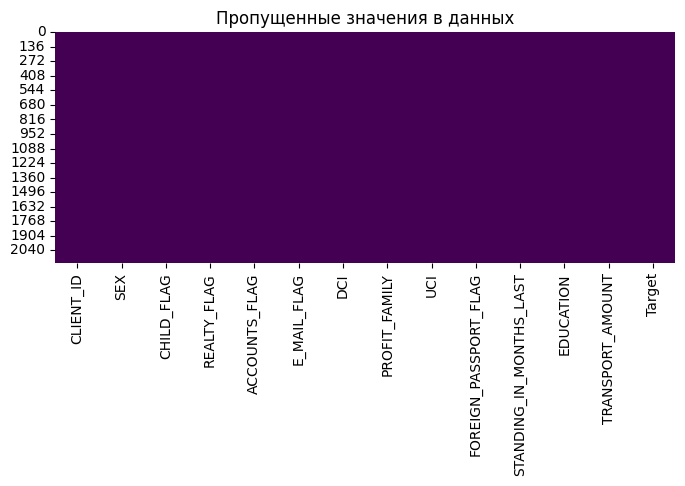

In [815]:
plt.figure(figsize=(8, 3))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в данных')
plt.show()

### 2.3 Распределение целевого признака

2024-05-22 19:07:12,211 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,243 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


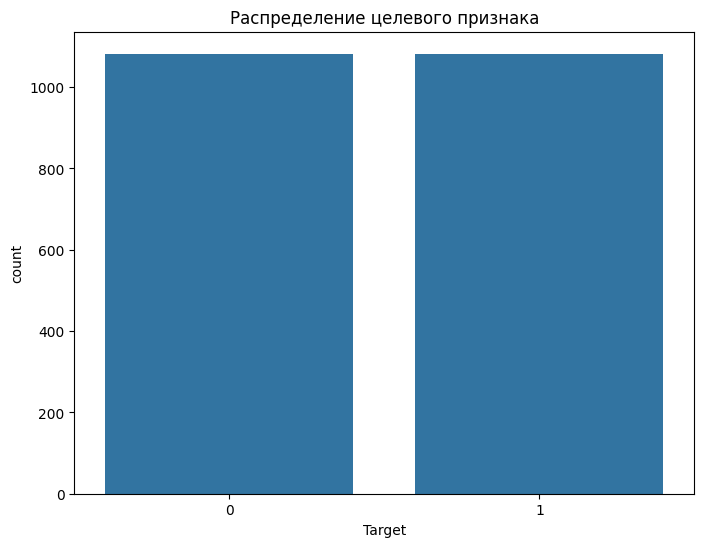

In [816]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=data)
plt.title('Распределение целевого признака')
plt.show()

### 2.4 Распределение категориальных признаков

2024-05-22 19:07:12,361 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,365 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,386 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,392 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,411 - INFO - Using categorical units to plot a list of strings that are all parsable as 

2024-05-22 19:07:12,446 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,469 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,474 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,487 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 19:07:12,490 - INFO - Using categorical units to plot a list of strings that are all parsable as 

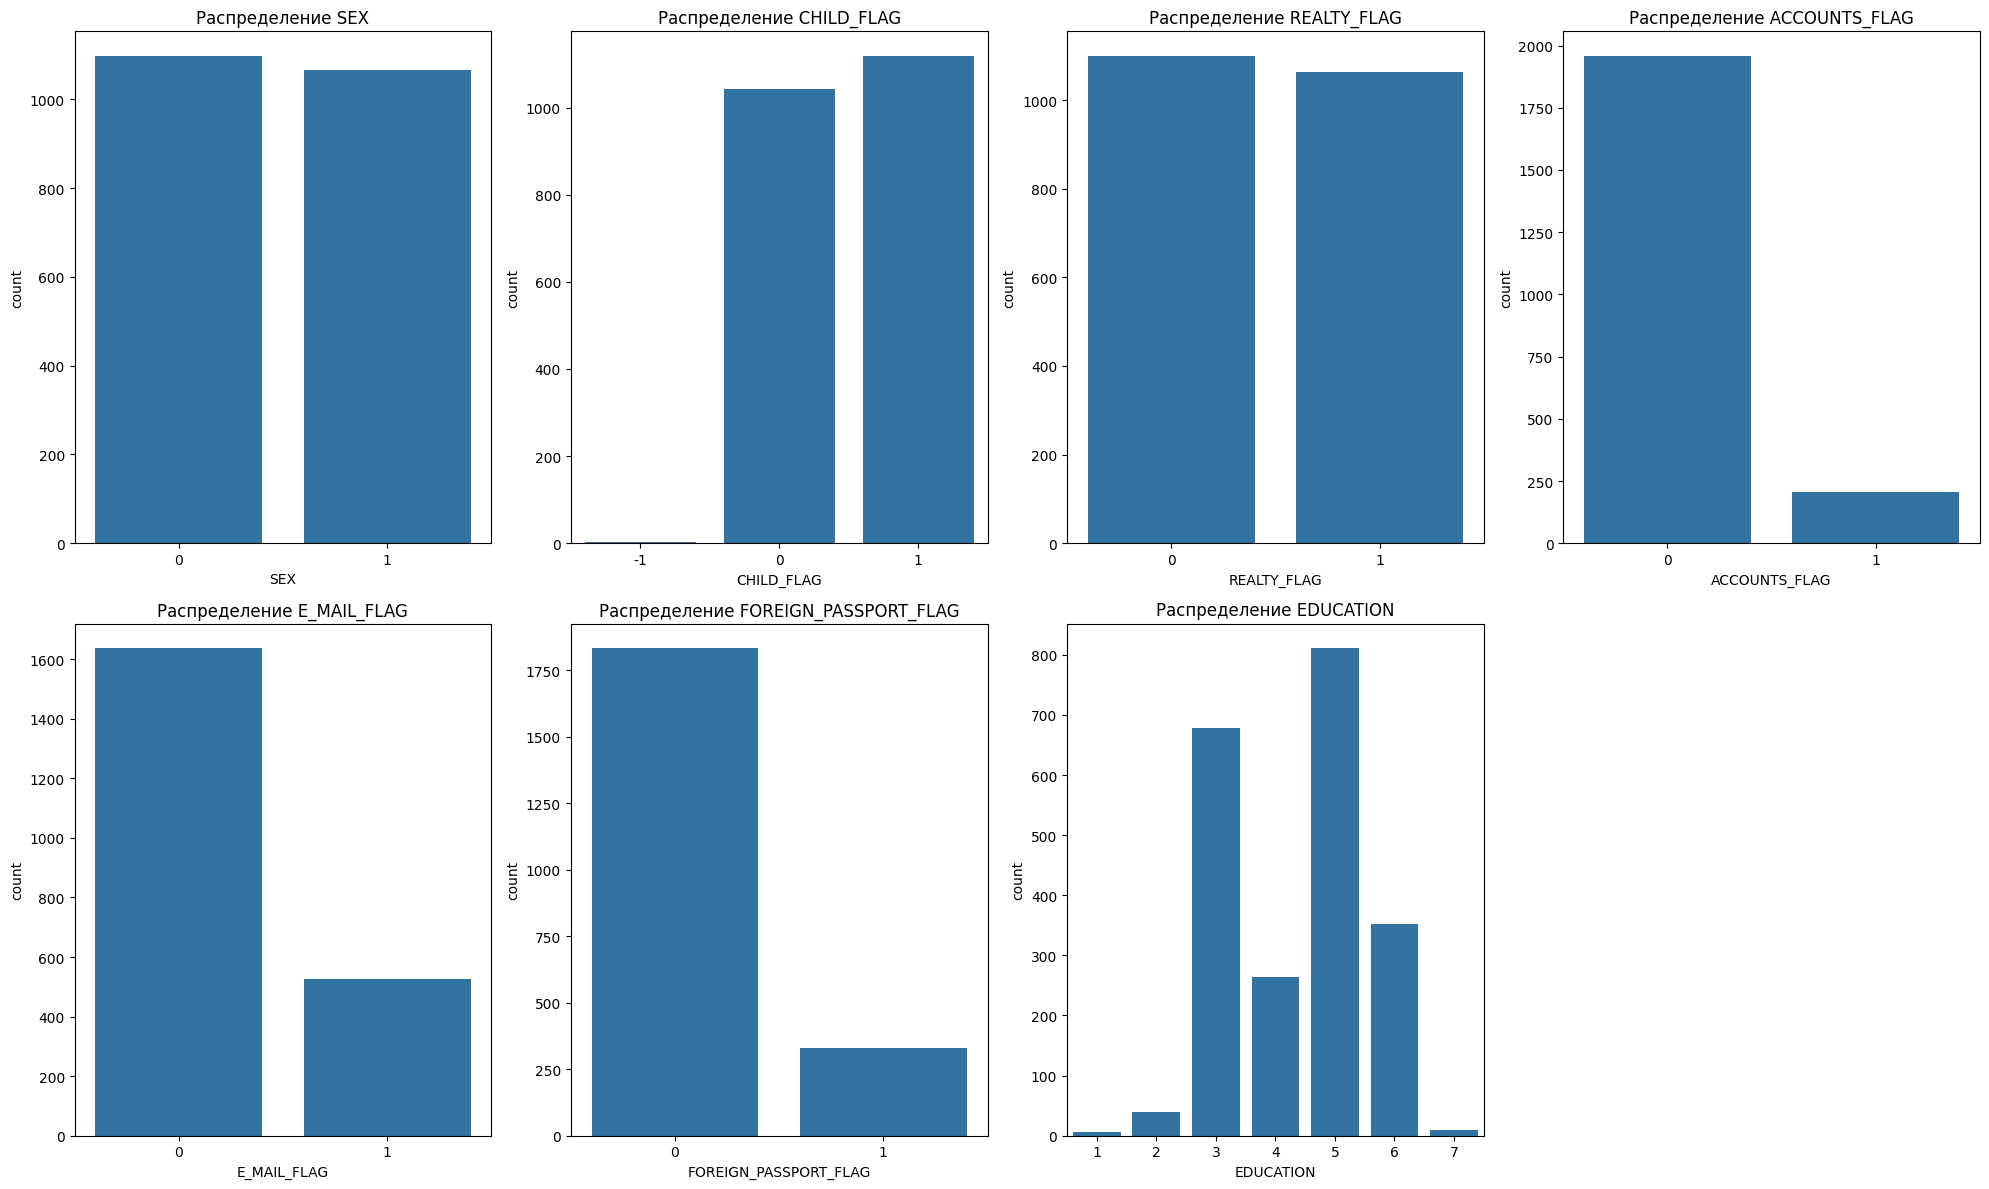

In [817]:
categorical_features = ['SEX', 'CHILD_FLAG', 'REALTY_FLAG', 'ACCOUNTS_FLAG', 'E_MAIL_FLAG', 'FOREIGN_PASSPORT_FLAG', 'EDUCATION']

plt.figure(figsize=(20, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, data=data)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

### 2.5 Распределение числовых признаков

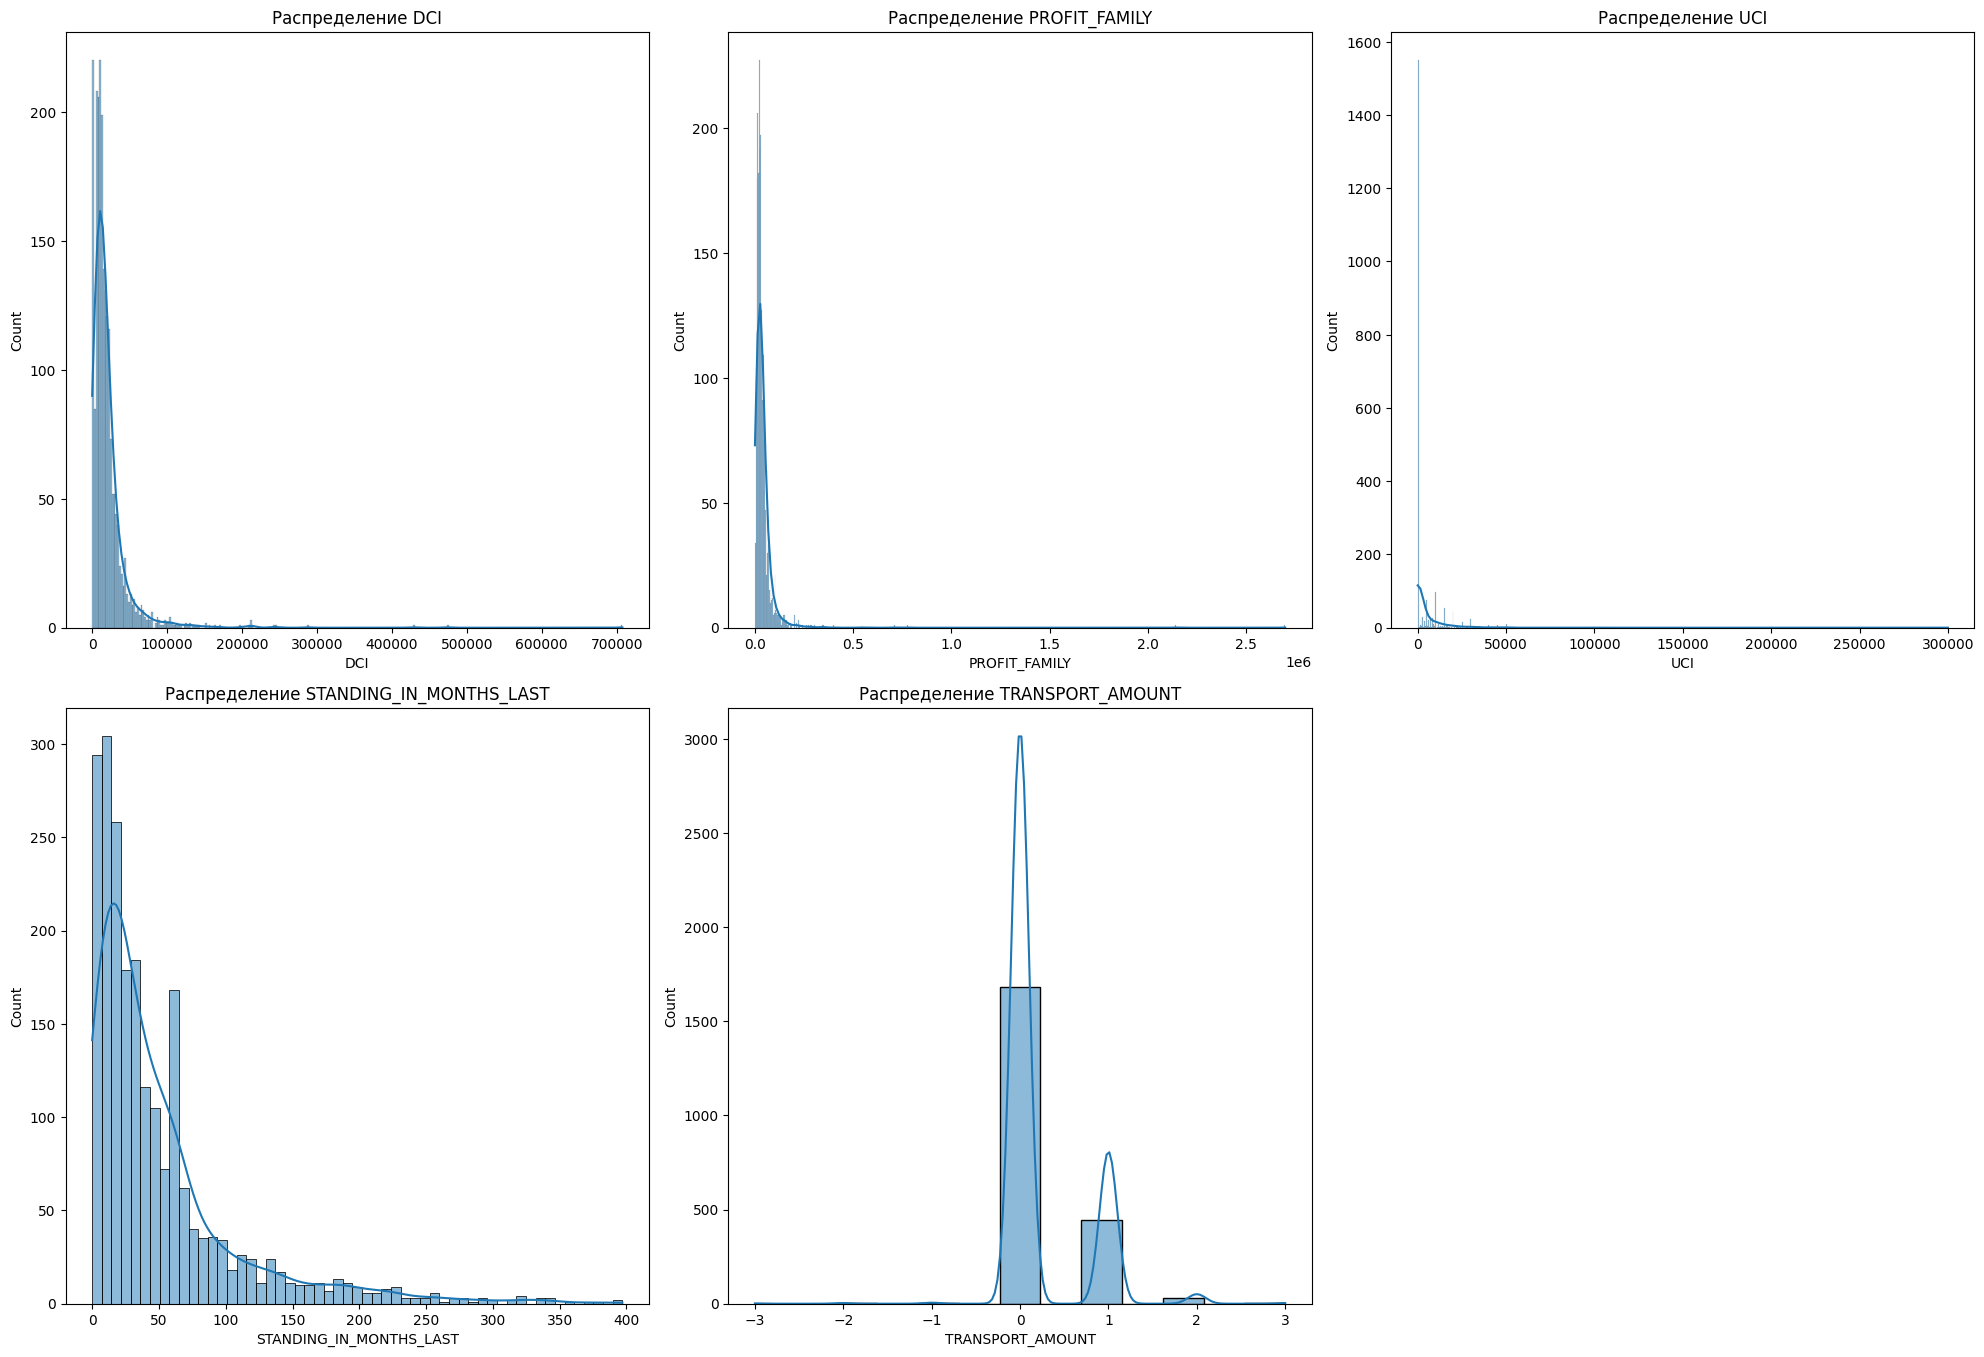

In [818]:
numeric_features = ['DCI', 'PROFIT_FAMILY', 'UCI', 'STANDING_IN_MONTHS_LAST', 'TRANSPORT_AMOUNT']

plt.figure(figsize=(20, 20))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

### 2.6 Корреляционный анализ

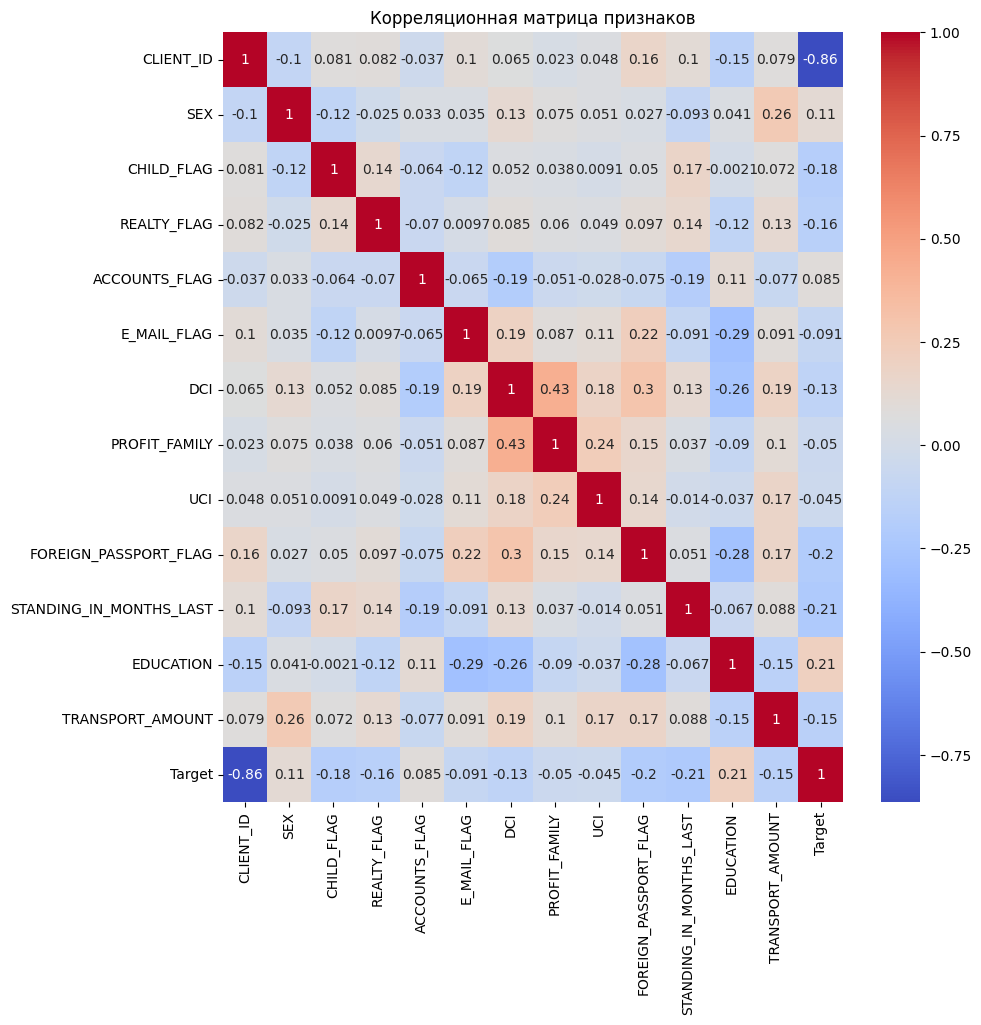

In [819]:
plt.figure(figsize=(10, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()


## Шаг 3: Обработка данных


### 3.1 Исправление значений CHILD_FLAG

In [820]:
data['CHILD_FLAG'] = data['CHILD_FLAG'].apply(lambda x: 0 if x < 0 else x)

### 3.2 Обработка аномальных значений

In [821]:
for column in ['DCI', 'PROFIT_FAMILY', 'UCI', 'STANDING_IN_MONTHS_LAST']:
    upper_limit = data[column].quantile(0.99)
    data[column] = data[column].apply(lambda x: upper_limit if x > upper_limit else x)

### 3.3 Обработка TRANSPORT_AMOUNT

In [822]:
data['TRANSPORT_AMOUNT'] = data['TRANSPORT_AMOUNT'].apply(lambda x: 0 if x < 0 else x)

### 3.4 Удаление CLIENT_ID из-за высокой корреляции

In [823]:
data = data.drop(columns=['CLIENT_ID'])

## Шаг 4: Feature Engineering
### 4.1 Кодирование категориальных признаков

In [824]:
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])


## Шаг 5: Подготовка данных

In [825]:
features = list(data.columns)
features.remove('Target')
target = 'Target'

X = data[features]
y = data[target]

X = X.sample(frac=1, random_state=42).reset_index(drop=True)
y = y.sample(frac=1, random_state=42).reset_index(drop=True)

scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])


## Шаг 6: Разделение данных на обучающую и тестовую выборки

In [826]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)


In [827]:
print(f"Размер обучающей выборки: {X_train.shape}, {y_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}, {y_test.shape}")

print("Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print("Распределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Размер обучающей выборки: (1730, 12), (1730,)
Размер тестовой выборки: (433, 12), (433,)
Распределение классов в обучающей выборке:
Target
0    0.5
1    0.5
Name: proportion, dtype: float64
Распределение классов в тестовой выборке:
Target
1    0.501155
0    0.498845
Name: proportion, dtype: float64


## Шаг 7: Моделирование
### 7.1 Обучение и сравнение нескольких моделей

In [828]:
models = {
    'CatBoost': (CatBoostClassifier(verbose=0), {
        'iterations': [77, 80, 82],
        'depth': [3],
        'learning_rate': [0.09, 0.1, 0.11],
        'l2_leaf_reg': [2, 3, 4],
        'bagging_temperature': [0.1, 0.2],
        'border_count': [25, 32, 40],
        'grow_policy': ['Lossguide'],
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [80, 100, 150],
        'max_depth': [4, 5, 6],
        'min_samples_split': [1, 2, 3]
    }),
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'C': [30, 40, 50],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    })
}

In [829]:
results = {}
best_params = {}
for model_name, (model, param_grid) in models.items():
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    cv_results = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='accuracy')
    results[model_name] = cv_results
    best_params[model_name] = grid_search.best_params_

    print(f'{model_name} Best Params: {grid_search.best_params_}')
    print(f'{model_name}: {cv_results.mean()} ± {cv_results.std()}')



CatBoost Best Params: {'bagging_temperature': 0.1, 'border_count': 32, 'depth': 3, 'grow_policy': 'Lossguide', 'iterations': 80, 'l2_leaf_reg': 2, 'learning_rate': 0.1}
CatBoost: 0.6907514450867053 ± 0.01864105837756889


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/

RandomForest Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest: 0.6780346820809249 ± 0.017205637070678872
LogisticRegression Best Params: {'C': 40, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression: 0.6722543352601156 ± 0.02595369285623542


In [830]:
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name][0].set_params(**best_params[best_model_name])

In [831]:
best_model.fit(X_train, y_train)

### 7.2 Оценка модели

In [832]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report')


Accuracy: 0.6327944572748267
ROC AUC Score: 0.6724910394265232
Confusion Matrix:
[[128  88]
 [ 71 146]]
Classification Report


## Визуализация метрик модели
### ROC-кривая

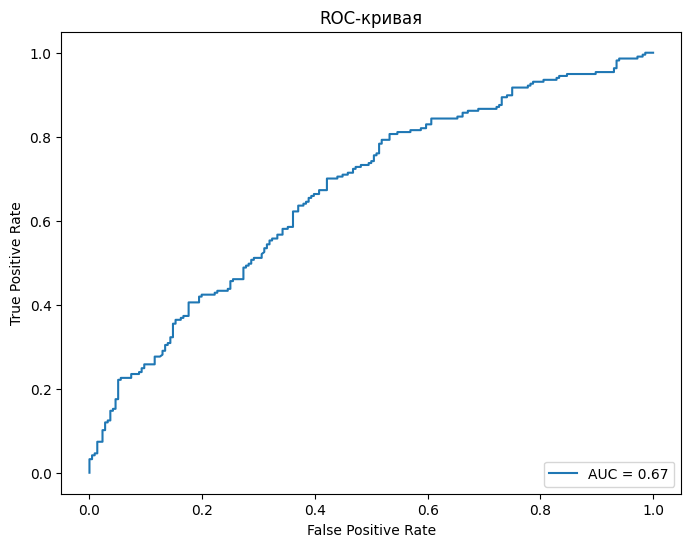

In [833]:
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

### Precision-Recall кривая

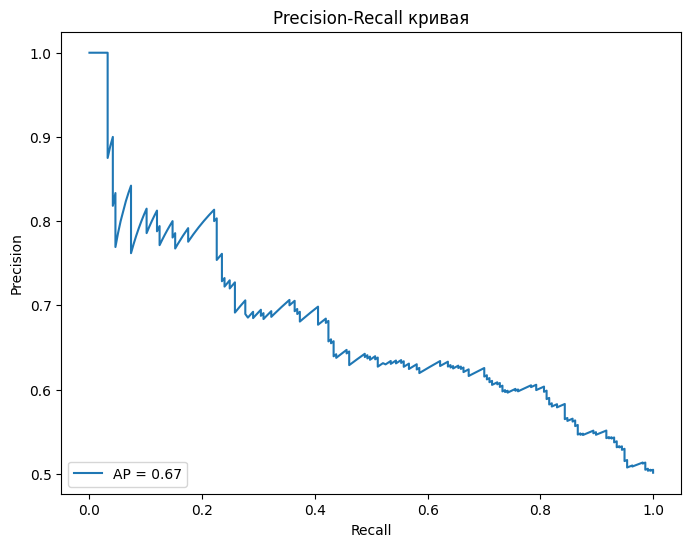

In [834]:
precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1]):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc='lower left')
plt.show()


## Шаг 8: Улучшение модели
### 8.1 Балансировка данных с использованием SMOTETomek

In [835]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)


### 8.2 Обучение модели с лучшими параметрами на сбалансированных данных

In [836]:
best_model_balanced = best_model
best_model_balanced.fit(X_train_balanced, y_train_balanced)

### 8.3 Оценка улучшенной модели

In [837]:
y_pred_balanced = best_model_balanced.predict(X_test)

accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
class_report_balanced = classification_report(y_test, y_pred_balanced)
roc_auc_balanced = roc_auc_score(y_test, best_model_balanced.predict_proba(X_test)[:, 1])

print(f'Accuracy (balanced): {accuracy_balanced}')
print(f'ROC AUC Score (balanced): {roc_auc_balanced}')
print(f'Confusion Matrix (balanced):\n{conf_matrix_balanced}')
print(f'Classification Report (balanced):\n{class_report_balanced}')

Accuracy (balanced): 0.6235565819861432
ROC AUC Score (balanced): 0.6698348694316436
Confusion Matrix (balanced):
[[127  89]
 [ 74 143]]
Classification Report (balanced):
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       216
           1       0.62      0.66      0.64       217

    accuracy                           0.62       433
   macro avg       0.62      0.62      0.62       433
weighted avg       0.62      0.62      0.62       433



## Визуализация метрик улучшенной модели
### ROC-кривая (улучшенная модель)

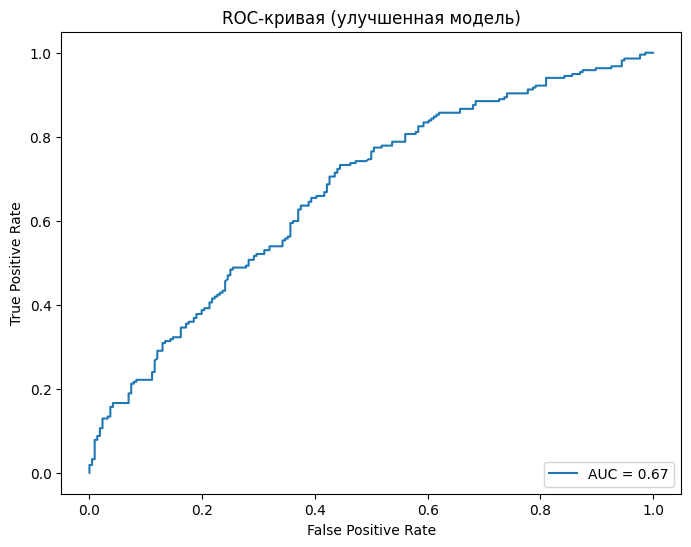

In [838]:
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, best_model_balanced.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, label=f'AUC = {roc_auc_balanced:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (улучшенная модель)')
plt.legend(loc='lower right')
plt.show()

### Precision-Recall кривая (улучшенная модель)

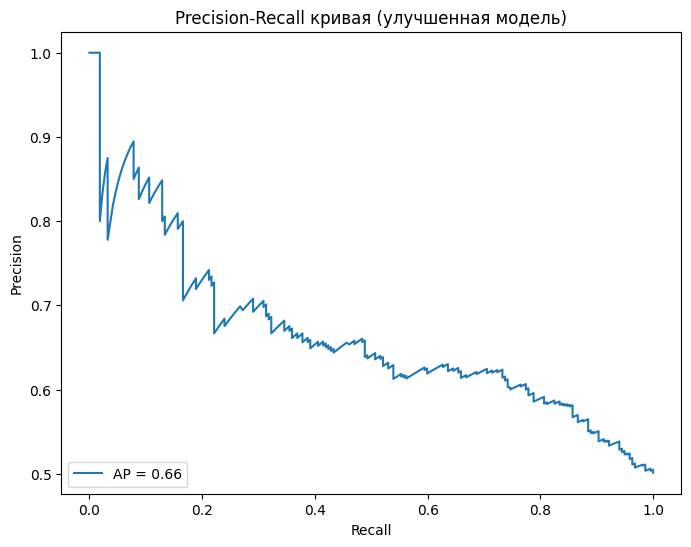

In [839]:
precision_balanced, recall_balanced, _ = precision_recall_curve(y_test, best_model_balanced.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall_balanced, precision_balanced, label=f'AP = {average_precision_score(y_test, best_model_balanced.predict_proba(X_test)[:, 1]):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая (улучшенная модель)')
plt.legend(loc='lower left')
plt.show()


## Шаг 9: Использование ансамблевых методов
### 9.1 Stacking моделей

In [840]:
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('catboost', CatBoostClassifier(eval_metric='AUC', verbose=200))
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=2000, random_state=42))

stacking_model.fit(X_train_balanced, y_train_balanced)

y_pred_stacking = stacking_model.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, stacking_model.predict_proba(X_test)[:, 1])

print(f'Stacking Accuracy: {accuracy_stacking}')
print(f'Stacking ROC AUC Score: {roc_auc_stacking}')


Learning rate set to 0.011887
0:	total: 9.17ms	remaining: 9.16s
200:	total: 220ms	remaining: 874ms
400:	total: 406ms	remaining: 607ms
600:	total: 606ms	remaining: 402ms
800:	total: 789ms	remaining: 196ms
999:	total: 977ms	remaining: 0us
Learning rate set to 0.010805
0:	total: 1.79ms	remaining: 1.78s
200:	total: 177ms	remaining: 703ms
400:	total: 356ms	remaining: 531ms
600:	total: 533ms	remaining: 354ms
800:	total: 706ms	remaining: 176ms
999:	total: 883ms	remaining: 0us
Learning rate set to 0.010805
0:	total: 1.5ms	remaining: 1.5s
200:	total: 177ms	remaining: 702ms
400:	total: 366ms	remaining: 546ms
600:	total: 553ms	remaining: 367ms
800:	total: 742ms	remaining: 184ms
999:	total: 916ms	remaining: 0us
Learning rate set to 0.010805
0:	total: 907us	remaining: 907ms
200:	total: 176ms	remaining: 701ms
400:	total: 351ms	remaining: 525ms
600:	total: 523ms	remaining: 347ms
800:	total: 697ms	remaining: 173ms
999:	total: 953ms	remaining: 0us
Learning rate set to 0.010809
0:	total: 1.34ms	remainin

## Визуализация метрик модели Stacking
### ROC-кривая (Stacking модель)

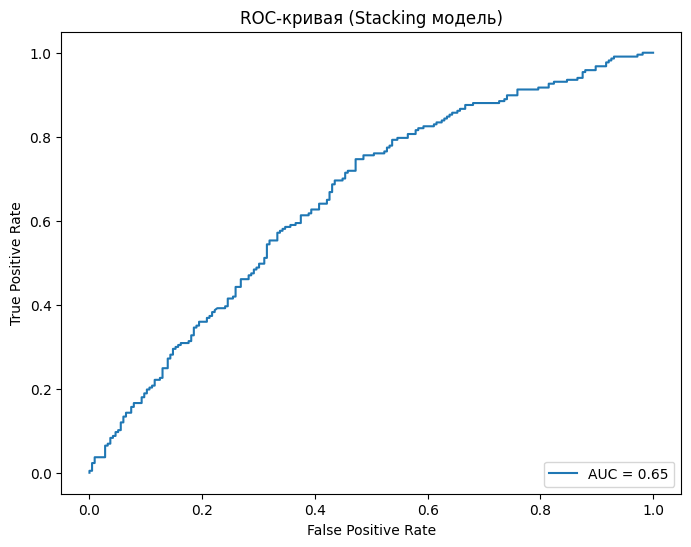

In [841]:
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, stacking_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking, tpr_stacking, label=f'AUC = {roc_auc_stacking:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (Stacking модель)')
plt.legend(loc='lower right')
plt.show()


### Precision-Recall кривая (Stacking модель)

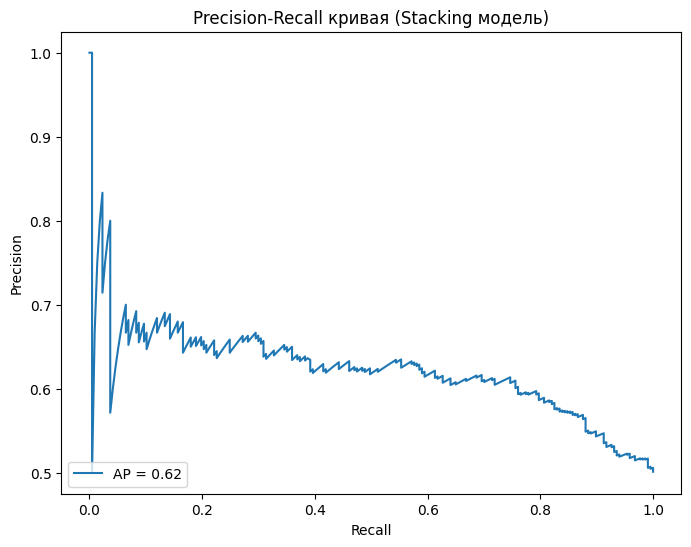

In [842]:
precision_stacking, recall_stacking, _ = precision_recall_curve(y_test, stacking_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall_stacking, precision_stacking, label=f'AP = {average_precision_score(y_test, stacking_model.predict_proba(X_test)[:, 1]):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая (Stacking модель)')
plt.legend(loc='lower left')
plt.show()


In [843]:
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])

y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f'Accuracy (Train): {train_accuracy}')
print(f'ROC AUC Score (Train): {train_roc_auc}')
print(f'Accuracy (Test): {test_accuracy}')
print(f'ROC AUC Score (Test): {test_roc_auc}')


Accuracy (Train): 0.7092485549132947
ROC AUC Score (Train): 0.7745631327475024
Accuracy (Test): 0.6235565819861432
ROC AUC Score (Test): 0.6698348694316436


In [844]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X, y, cv=StratifiedKFold(n_splits=10), scoring='roc_auc')
print(f'Cross-validated ROC AUC: {cv_scores.mean()} ± {cv_scores.std()}')

Cross-validated ROC AUC: 0.7205559566957374 ± 0.027926692900684665


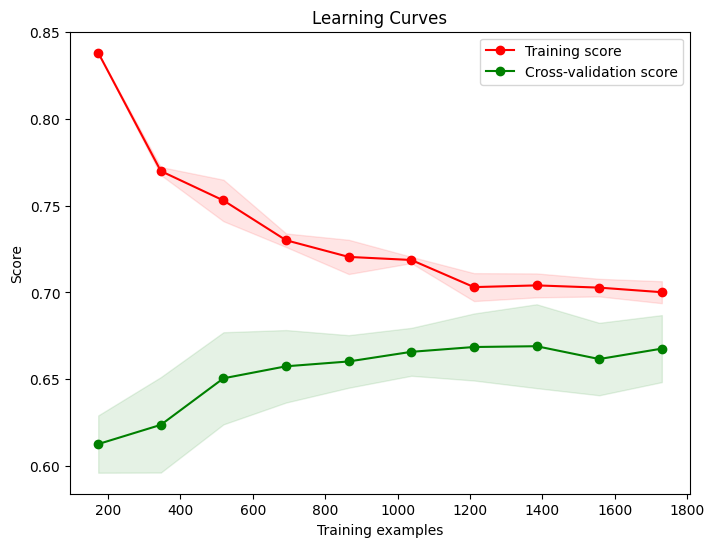

In [845]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


1. **Статистика по моделям CatBoostClassifier**:
   - **Обучающая выборка**:
     - **Accuracy (Train)**: 0.709
     - **ROC AUC Score (Train)**: 0.775
   - **Тестовая выборка**:
     - **Accuracy (Test)**: 0.624
     - **ROC AUC Score (Test)**: 0.670

2. **Stacking Model**:
   - **Общая точность (Stacking Accuracy)**: 0.610
   - **ROC AUC Score (Stacking)**: 0.654

3. **Cross-validated ROC AUC**:
   - **Средний ROC AUC с кросс-валидацией**: 0.720
   - **Дисперсия**: ± 0.020


### 10. Сохраниение модели

In [857]:
model_filename = 'trained_model.pkl'
joblib.dump(best_model, model_filename)
print(f'Model saved to {model_filename}')

Model saved to trained_model.pkl
